# Imports

In [22]:
data_path = 'data/hepatitis.data'

In [64]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone

from scipy.stats import ttest_ind

import matplotlib.patches as mpatches

pd.set_option('display.max_rows', None)

# Load data

In [24]:
columns = ['class', 'age', 'sex', 'seroid', 'antviral',
           'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm',
           'spleen_palpable',  'spiders', 'ascites', 'varices', 'bilirubin', 
           'alk_phosphate', 'sgot', 'albumin', 'protime', 'histology']

columns_to_drop = ['alk_phosphate', 'protime']

df = pd.read_csv(data_path, names=columns)

## Sanitize data

In [25]:
# drop columns with many empty records
df = df.drop(columns_to_drop, axis=1)
# mark '?' as NaN
df = df[df != '?']
# drop NaN
df = df.dropna()
df = df.reset_index(drop=True)
# convert 'Object' type to floats and ints
df[['bilirubin', 'sgot', 'albumin']] = df[['bilirubin', 'sgot', 'albumin']].astype('float')
df[['class', 'sex', 'seroid', 'antviral', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']] = df[['class', 'sex', 'seroid', 'antviral', 'fatigue', 'malaise', 'anorexia', 'liver_big', 'liver_firm', 'spleen_palpable', 'spiders', 'ascites', 'varices', 'histology']].astype(int)
# replace class marks
df.replace({1: 0, 2: 1}, inplace=True)
# divdie df to X and y sets
X = df.drop(['class'], axis=1)
y = df['class']

X.head()

,age,sex,seroid,antviral,fatigue,malaise,anorexia,liver_big,liver_firm,spleen_palpable,spiders,ascites,varices,bilirubin,sgot,albumin,histology
0,30,1,0,1,1,1,1,0,1,1,1,1,1,0.0,18.0,4.0,0
1,50,0,0,1,0,1,1,0,1,1,1,1,1,0.9,42.0,3.5,0
2,78,0,1,1,0,1,1,1,1,1,1,1,1,0.7,32.0,4.0,0
3,34,0,1,1,1,1,1,1,1,1,1,1,1,0.0,200.0,4.0,0
4,34,0,1,1,1,1,1,1,1,1,1,1,1,0.9,28.0,4.0,0


# Features ranking

In [26]:
# use chi-squared test to make features ranking
chi2_selector = SelectKBest(chi2, k=X.shape[1])
data = chi2_selector.fit(X, y)

## Ranking table

In [27]:
# create ranking table
chi2_scores = pd.DataFrame(list(zip(X.columns, chi2_selector.scores_)), columns=['feature', 'score'])
chi2_scores = chi2_scores.round(2)
chi2_scores = chi2_scores.sort_values('score', ascending=False)

## Bar plot

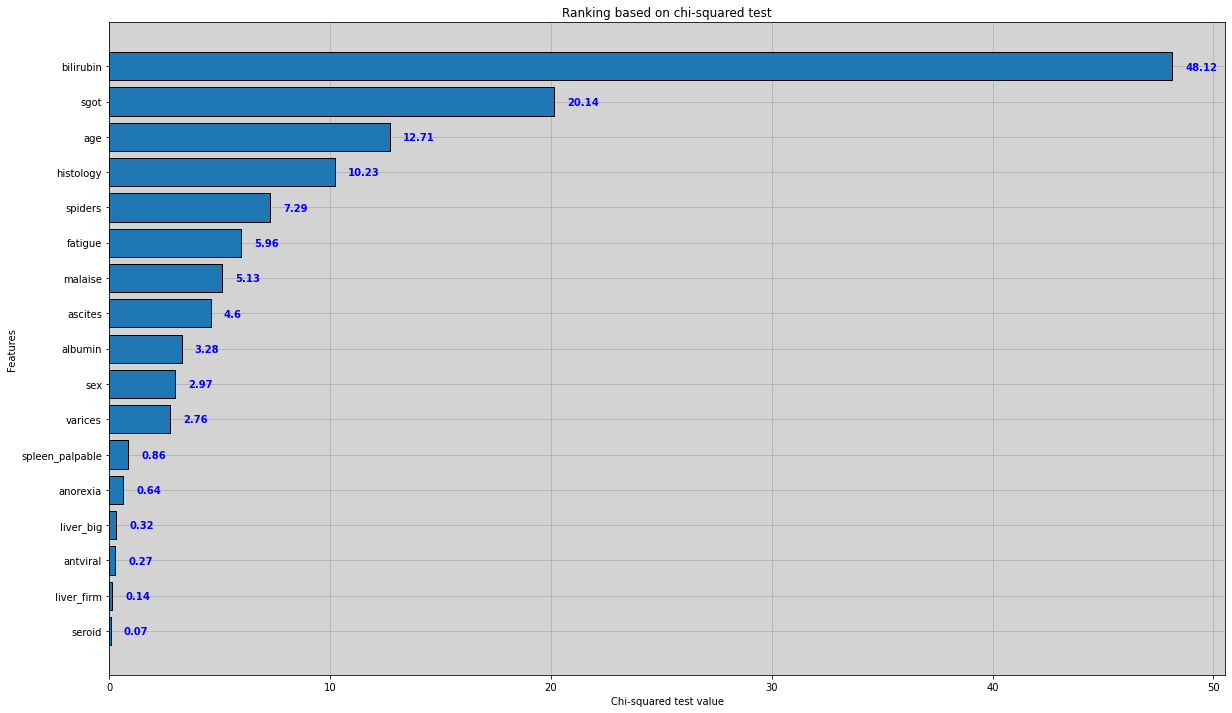

In [28]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)
estimator_num = len(chi2_scores['feature'])

# sort ascending because horizontal bars print in reverse order
ascending_features = chi2_scores.sort_values('score', ascending=True)

# create horizontal bar plot
plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')

# label bars and axis
plt.yticks(range(estimator_num), ascending_features['feature'])
plt.title('Ranking based on chi-squared test')
plt.ylabel('Features')
plt.xlabel('Chi-squared test value')

# add scores at bars end
for i, v in enumerate(ascending_features['score']):
    plt.text(v + 0.6, i - 0.1, str(v), color='blue', fontweight='bold')

# save to file must be call before show
plt.savefig(fname='ranking.png', orientation='landscape')
plt.show()

In [29]:
# chi2_support = chi2_selector.get_support()
# chi2_feature = X.loc[:,chi2_support].columns.tolist()
# print(chi2_feature)

In [30]:
# X_norm_striped = MinMaxScaler().fit_transform(X[chi2_feature])
# df = pd.DataFrame(data=X[chi2_feature], columns=chi2_feature)
# df.head()

# Experimental environment

### Classifiers declaration

In [31]:
clfs = {
    '512_momentum': MLPClassifier(hidden_layer_sizes=512, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '256_momentum': MLPClassifier(hidden_layer_sizes=256, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '128_momentum': MLPClassifier(hidden_layer_sizes=128, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='sgd',momentum=0.9),
    '512_no_momentum': MLPClassifier(hidden_layer_sizes=512, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0),
    '256_no_momentum': MLPClassifier(hidden_layer_sizes=256, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0),
    '128_no_momentum': MLPClassifier(hidden_layer_sizes=128, verbose=True, max_iter=500, early_stopping=True, n_iter_no_change=20, solver='adam', momentum=0)
}

In [32]:
n_splits = 2
n_repeats = 5
number_of_features = len(X.columns)
clfs_amount = len(clfs)

In [33]:
# result of every single k-fold 
accuracy_scores = np.zeros((len(clfs), number_of_features, n_splits * n_repeats))

### Model fitting with cross validation

In [34]:
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

In [35]:

for features_index in range(number_of_features):
    k_best_selector = SelectKBest(chi2, k=features_index + 1)
    selected_data = k_best_selector.fit_transform(X, y)

    for fold_id, (train_index, test_index) in enumerate(rskf.split(selected_data, y)):
        for clf_id, clf_name in enumerate(clfs):
            X_train, X_test = selected_data[train_index], selected_data[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            clf = clfs[clf_name]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accuracy_scores[clf_id, features_index, fold_id] = accuracy_score(y_test, y_pred)


on 11, loss = 0.53436078
Validation score: 1.000000
Iteration 12, loss = 0.44563796
Validation score: 0.857143
Iteration 13, loss = 0.43951423
Validation score: 0.857143
Iteration 14, loss = 0.47328416
Validation score: 0.857143
Iteration 15, loss = 0.49395140
Validation score: 0.857143
Iteration 16, loss = 0.48588979
Validation score: 0.857143
Iteration 17, loss = 0.45342909
Validation score: 0.857143
Iteration 18, loss = 0.41129935
Validation score: 1.000000
Iteration 19, loss = 0.38299237
Validation score: 1.000000
Iteration 20, loss = 0.38533598
Validation score: 1.000000
Iteration 21, loss = 0.40226712
Validation score: 1.000000
Iteration 22, loss = 0.40016309
Validation score: 1.000000
Iteration 23, loss = 0.37573079
Validation score: 1.000000
Iteration 24, loss = 0.35208572
Validation score: 1.000000
Iteration 25, loss = 0.34423461
Validation score: 1.000000
Iteration 26, loss = 0.34869647
Validation score: 0.857143
Iteration 27, loss = 0.35398914
Validation score: 0.857143
Iter

In [36]:
means = np.mean(accuracy_scores, axis=2)

In [37]:
print("=== Classifier, features, k-fold mean ===")
for clf_id, clf_name in enumerate(clfs):
    print(f"--- Classifier: {clf_name} ---")
    for feature_index in range(number_of_features):
        cls_mean = means[clf_id,feature_index]
        print("Features: %d, mean: %.4f" % (feature_index+1, cls_mean))

=== Classifier, features, k-fold mean ===
--- Classifier: 512_momentum ---
Features: 1, mean: 0.7863
Features: 2, mean: 0.8139
Features: 3, mean: 0.8093
Features: 4, mean: 0.7982
Features: 5, mean: 0.7847
Features: 6, mean: 0.8124
Features: 7, mean: 0.8139
Features: 8, mean: 0.7952
Features: 9, mean: 0.7780
Features: 10, mean: 0.8139
Features: 11, mean: 0.8124
Features: 12, mean: 0.7739
Features: 13, mean: 0.8016
Features: 14, mean: 0.7924
Features: 15, mean: 0.7936
Features: 16, mean: 0.7770
Features: 17, mean: 0.8061
--- Classifier: 256_momentum ---
Features: 1, mean: 0.7783
Features: 2, mean: 0.8062
Features: 3, mean: 0.8047
Features: 4, mean: 0.8078
Features: 5, mean: 0.8063
Features: 6, mean: 0.7906
Features: 7, mean: 0.8139
Features: 8, mean: 0.8093
Features: 9, mean: 0.8155
Features: 10, mean: 0.7827
Features: 11, mean: 0.8108
Features: 12, mean: 0.7493
Features: 13, mean: 0.8016
Features: 14, mean: 0.7552
Features: 15, mean: 0.7800
Features: 16, mean: 0.7986
Features: 17, mean:

In [51]:
means.shape

(6, 17)

## Plots

### Plots with momentum

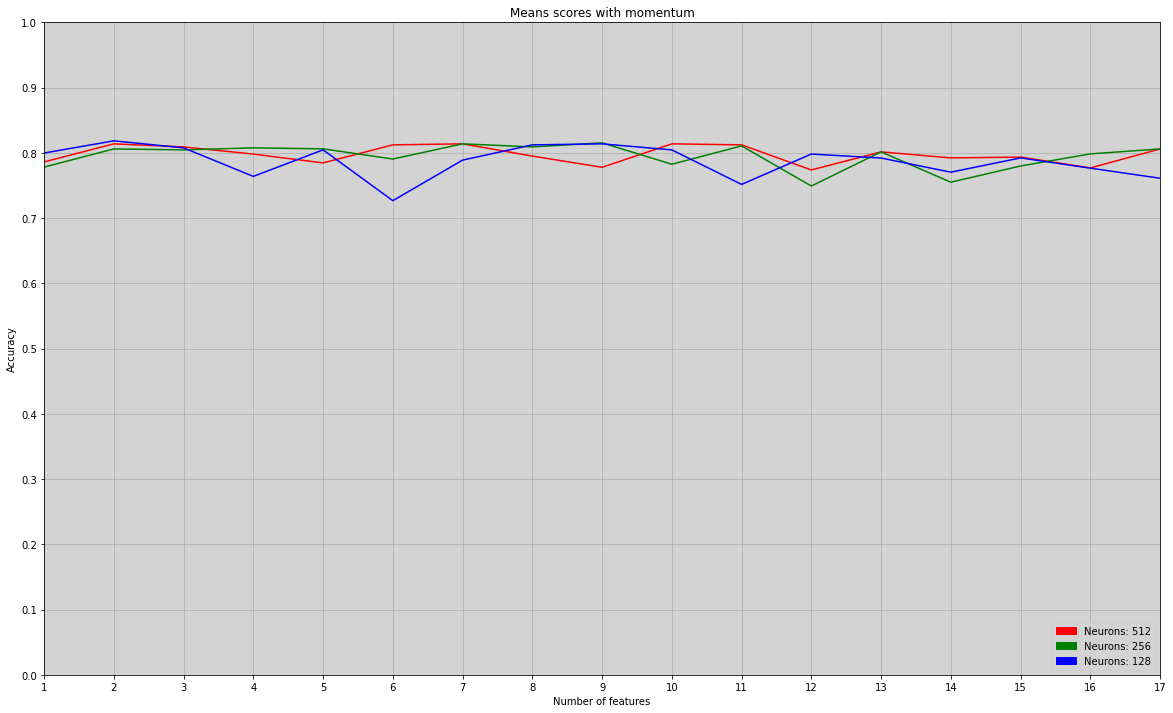

In [69]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)

plot_x = np.arange(1, number_of_features+1)
# create horizontal bar plot
# plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')
colors = ['red', 'green', 'blue']
for clf_id, clf_name in enumerate(clfs):
    if clf_id < 3: # only with momentum
        plt.plot(plot_x, means[clf_id], colors[clf_id])

# label bars and axis
axes = plt.gca()
axes.set_xlim([1,number_of_features])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(1, number_of_features+1, 1))
plt.title('Means scores with momentum')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

red_patch = mpatches.Patch(color='red', label='Neurons: 512')
green_patch = mpatches.Patch(color='green', label='Neurons: 256')
blue_patch = mpatches.Patch(color='blue', label='Neurons: 128')
legend_patches=[red_patch,green_patch,blue_patch]

# save to file must be call before show
plt.savefig(fname='means-with-momentum.png', orientation='landscape')
plt.legend(handles=legend_patches,loc=4)
plt.show()


### Plots without momentum

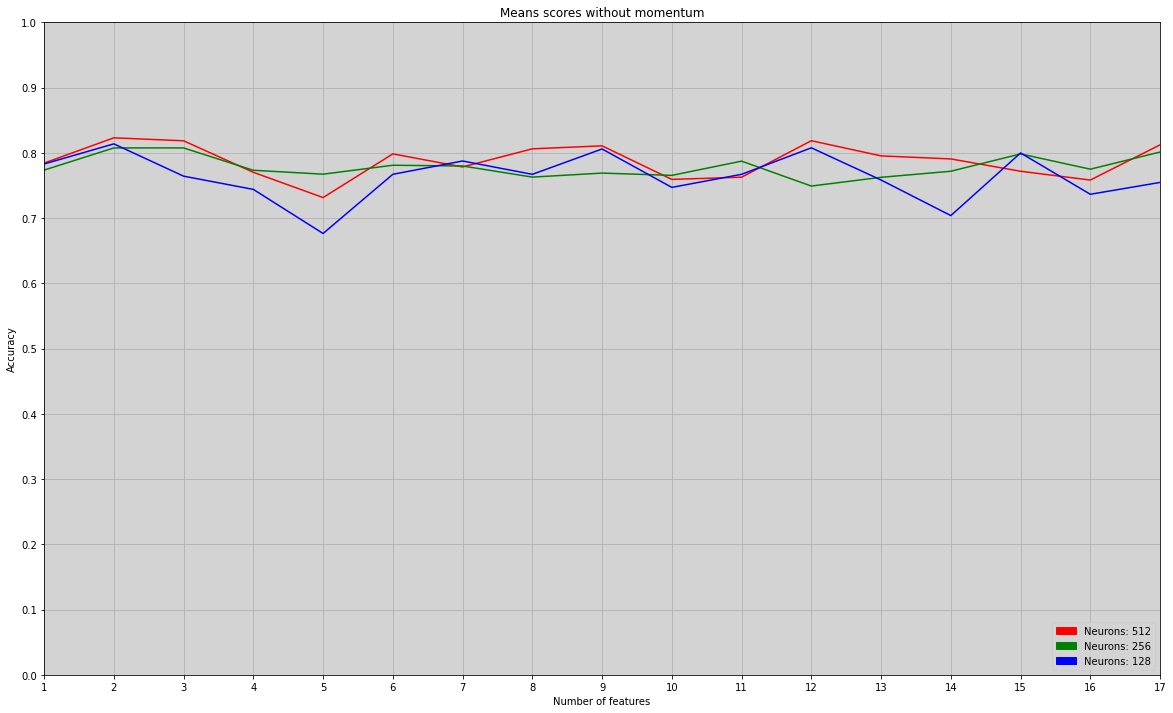

In [70]:
# display bar plot
plt.figure(figsize=(20,12))
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.grid(zorder=0)

plot_x = np.arange(1, number_of_features+1)
# create horizontal bar plot
# plt.barh(range(estimator_num), ascending_features['score'], align='center', zorder=3, edgecolor='black')
colors = ['red', 'green', 'blue']
for clf_id, clf_name in enumerate(clfs):
    if clf_id < 3: # only with no momentum
        plt.plot(plot_x, means[clf_id+3], colors[clf_id])

# label bars and axis
axes = plt.gca()
axes.set_xlim([1,number_of_features])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(1, number_of_features+1, 1))
plt.title('Means scores without momentum')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')

red_patch = mpatches.Patch(color='red', label='Neurons: 512')
green_patch = mpatches.Patch(color='green', label='Neurons: 256')
blue_patch = mpatches.Patch(color='blue', label='Neurons: 128')
legend_patches=[red_patch,green_patch,blue_patch]

# save to file must be call before show
plt.savefig(fname='means-without-momentum.png', orientation='landscape')
plt.legend(handles=legend_patches,loc=4)
plt.show()

# Statistical analysis 

In [18]:
t_statistics = np.zeros((number_of_features, clfs_amount, clfs_amount))
p_values = np.zeros((number_of_features, clfs_amount, clfs_amount))

In [19]:

for feat in range(number_of_features): # we compare every classifier with each other for every feature number
    for cls_a in range(clfs_amount):
        for cls_b in range(clfs_amount):
            a = accuracy_scores[cls_a][feat]
            b = accuracy_scores[cls_b][feat]
            t_statistics[feat][cls_a][cls_b], p_values[feat][cls_a][cls_b] = ttest_ind(a, b)

In [20]:

t_statistics = np.round(t_statistics, 2)
p_values = np.round(p_values, 2)

for feat in range(number_of_features): 
    print(f"=== Number of features: {feat} ===")
    for clf_a_id, clf_a_name in enumerate(clfs):
        for clf_b_id, clf_b_name in enumerate(clfs):
            print(f'\tClassifier {clf_a_name} compare to {clf_b_name}:')
            print(f'\tstatistic = {t_statistics[feat][clf_a_id][clf_b_id]}, pvalue = {p_values[feat][clf_a_id][clf_b_id]}')
            print()



are to 512_momentum:
	statistic = -0.75, pvalue = 0.46

	Classifier 256_no_momentum compare to 256_momentum:
	statistic = -0.35, pvalue = 0.73

	Classifier 256_no_momentum compare to 128_momentum:
	statistic = 1.26, pvalue = 0.22

	Classifier 256_no_momentum compare to 512_no_momentum:
	statistic = -2.01, pvalue = 0.06

	Classifier 256_no_momentum compare to 256_no_momentum:
	statistic = 0.0, pvalue = 1.0

	Classifier 256_no_momentum compare to 128_no_momentum:
	statistic = 1.7, pvalue = 0.11

	Classifier 128_no_momentum compare to 512_momentum:
	statistic = -2.09, pvalue = 0.05

	Classifier 128_no_momentum compare to 256_momentum:
	statistic = -1.91, pvalue = 0.07

	Classifier 128_no_momentum compare to 128_momentum:
	statistic = -0.22, pvalue = 0.83

	Classifier 128_no_momentum compare to 512_no_momentum:
	statistic = -2.63, pvalue = 0.02

	Classifier 128_no_momentum compare to 256_no_momentum:
	statistic = -1.7, pvalue = 0.11

	Classifier 128_no_momentum compare to 128_no_momentum:
